In [1]:
import pandas as pd
import datetime

interest_rates = pd.read_csv('Interest_rates.csv')
interest_rates['date'] = pd.to_datetime(interest_rates['date'], dayfirst=True)
interest_rates = interest_rates[interest_rates['date'] >= datetime.datetime(2021, 1, 1)]

In [2]:
dates = interest_rates.reset_index()['date'].tolist()
rates = interest_rates['interest_rate'].tolist()

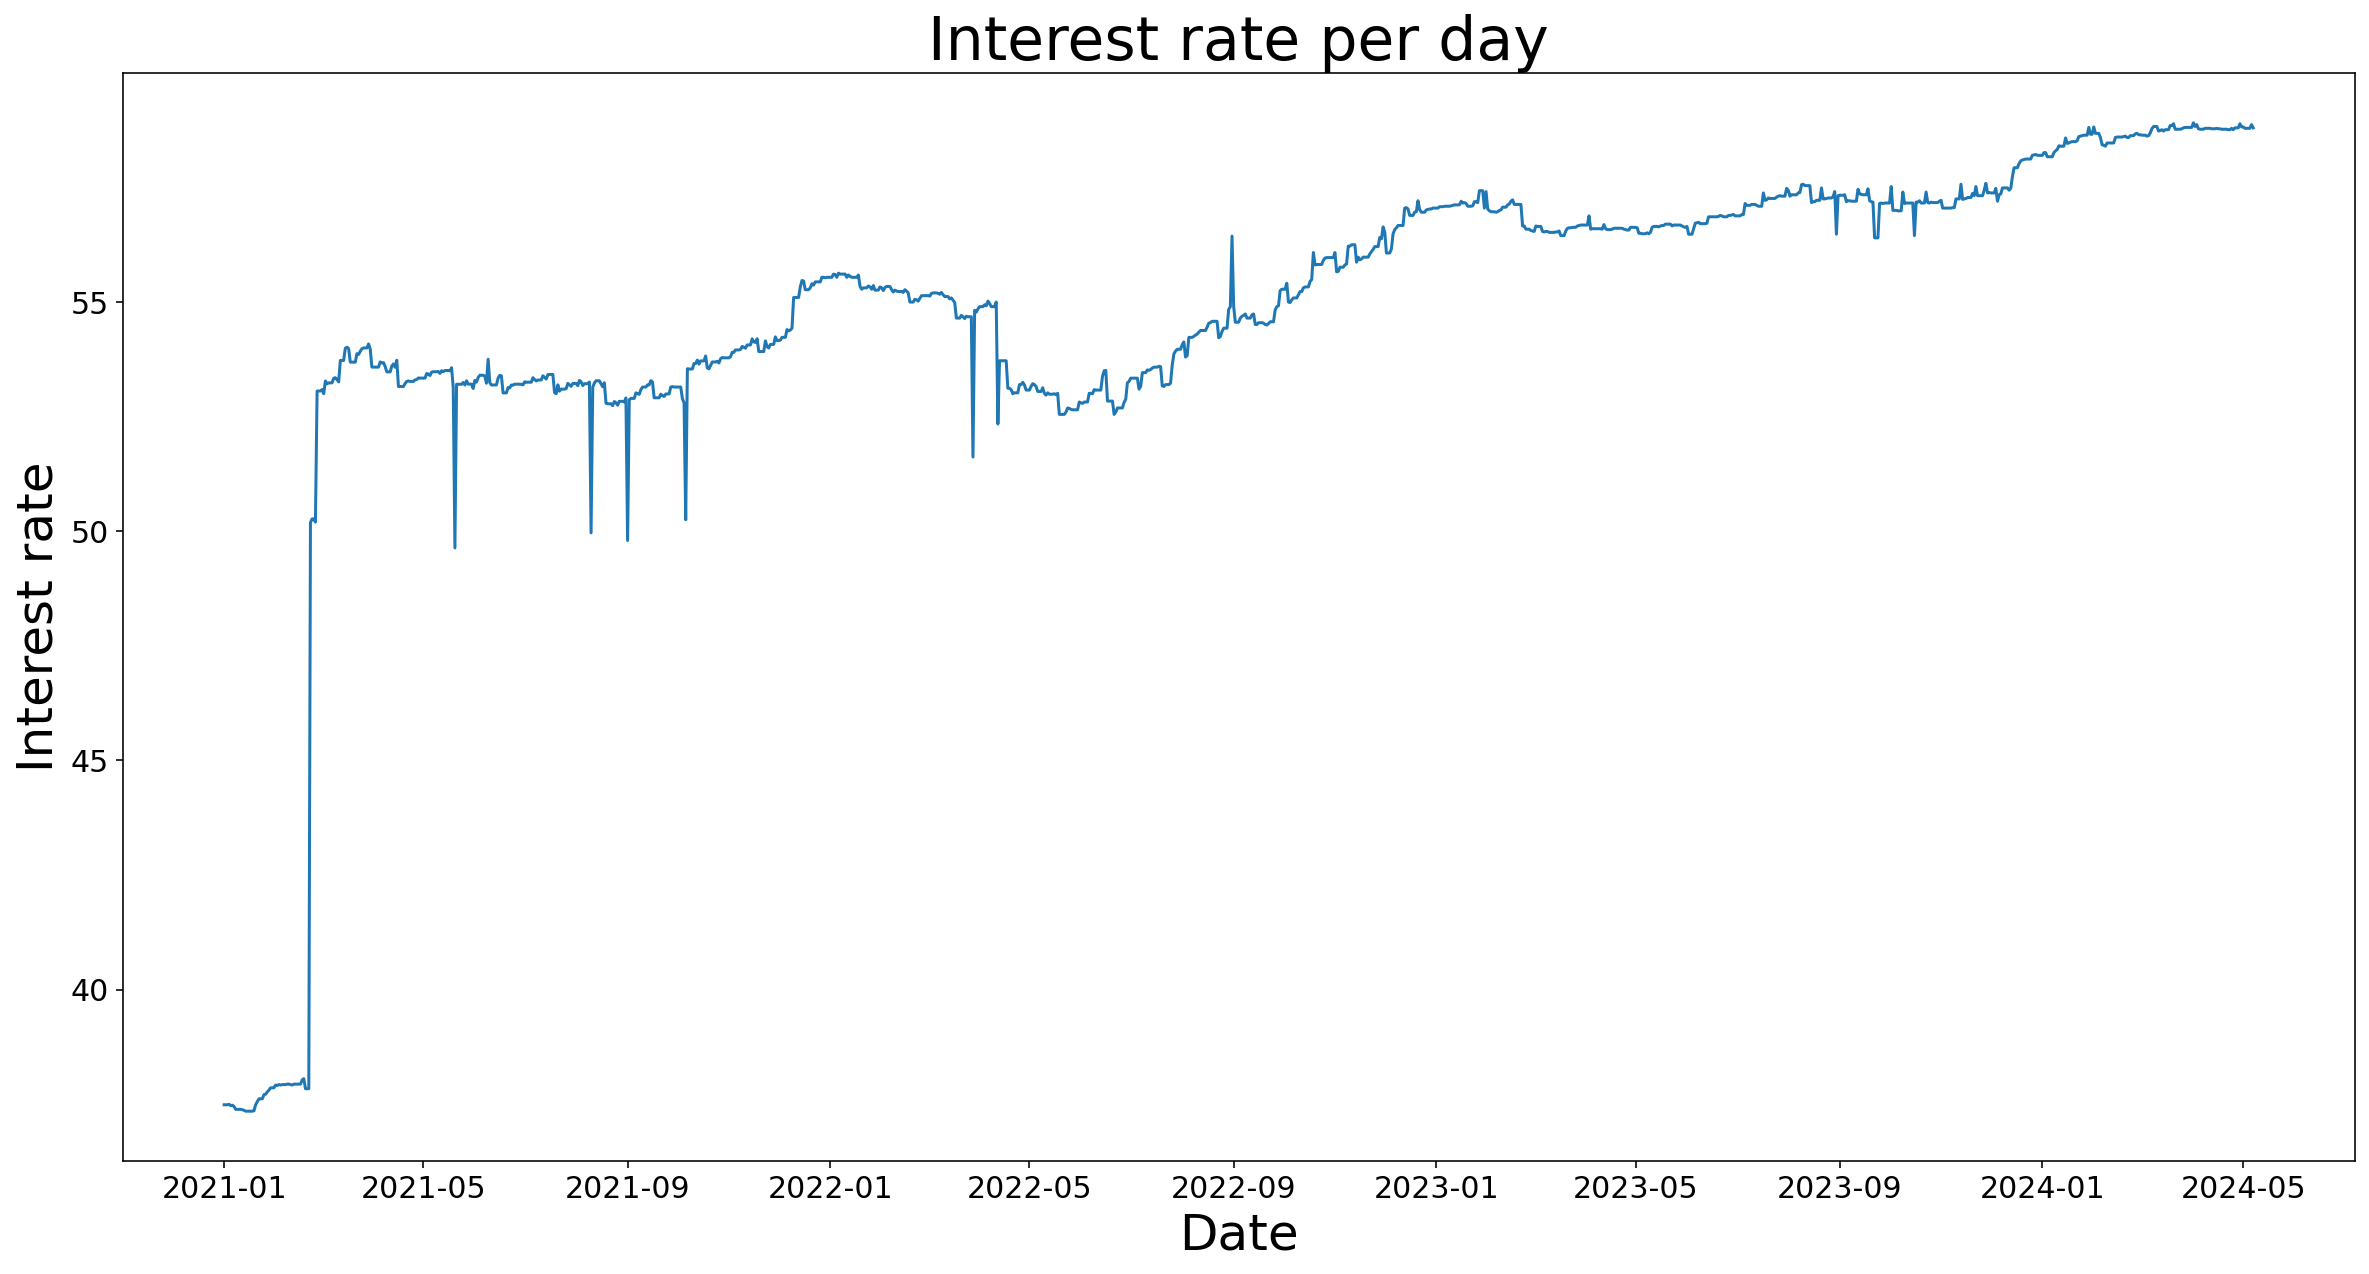

In [3]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 20, 10

plt.plot(dates, rates)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Interest rate', fontsize = 25)
plt.title('Interest rate per day', fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [4]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

period = 128
scaler = MinMaxScaler(feature_range=(0, 1))
test = rates[-period:]
test_dates = dates[-period:]
val = rates[-2*period:-period]
val_dates = dates[-2*period:-period]
train = scaler.fit_transform(np.array(rates[:-2*period]).reshape(-1, 1))

### Need to split train data into sequences. ###

In [5]:
def create_sequences(dataset, train_batch):
    X_train, Y_train = [], []
    for i in range(len(dataset)-train_batch):
        X_train.append(dataset[i:(i+train_batch), 0])
        Y_train.append(dataset[i+train_batch, 0])
    return np.array(X_train), np.array(Y_train)

### Let's tune the parameters including the train_batch parameter. ###

In [6]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

train_batch_values = [1, 3, 5, 7, 14, 21, 28, 35, 42, 49]
max_depth_values = range(1, 9)
eta_values = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
best_RMSE = np.inf
best_train_batch = 0
best_max_depth = 0
best_eta = 0

for train_batch_ in train_batch_values:
    X_train, y_train = create_sequences(train, train_batch_)
    for max_depth_ in max_depth_values:
        for eta_ in eta_values:
            model = XGBRegressor(random_state=42, n_estimators=1000, max_depth=max_depth_, eta=eta_)
            model.fit(X_train, y_train, verbose=False)
            X_train_ = train[-train_batch_:].reshape(1, train_batch_)
            val_pred = []
            for i in range(period):
                next_pred = model.predict(X_train_)
                X_train_ = X_train_.reshape(X_train_.shape[1])[1:]
                X_train_ = np.append(X_train_, next_pred)
                X_train_ = X_train_.reshape(1, train_batch_)
                val_pred.append(next_pred[0])
            val_pred = scaler.inverse_transform(np.array(val_pred).reshape(-1, 1)).reshape(period)
            val_RMSE = mean_squared_error(val, val_pred, squared=False)
            if val_RMSE < best_RMSE:
                best_RMSE = val_RMSE
                best_train_batch = train_batch_
                best_max_depth = max_depth_
                best_eta = eta_

print("Best RMSE = %.3f" % best_RMSE, sep="")
print("Best train batch = ", best_train_batch, sep="")
print("Best max depth = ", best_max_depth, sep="")
print("Best eta = ", best_eta, sep="")

Best RMSE = 0.355
Best train batch = 28
Best max depth = 2
Best eta = 0.3


### Best model predictions. ###

In [7]:
X_train, y_train = create_sequences(train, best_train_batch)
best_model = XGBRegressor(random_state=42, n_estimators=1000, max_depth=best_max_depth, eta=best_eta)
best_model.fit(X_train, y_train, verbose=False)
X_train_ = train[-best_train_batch:].reshape(1, best_train_batch)
val_pred = []
for i in range(period):
    next_pred = best_model.predict(X_train_)
    X_train_ = X_train_.reshape(X_train_.shape[1])[1:]
    X_train_ = np.append(X_train_, next_pred)
    X_train_ = X_train_.reshape(1, best_train_batch)
    val_pred.append(next_pred[0])

val_pred = scaler.inverse_transform(np.array(val_pred).reshape(-1, 1)).reshape(period)
val_RMSE = mean_squared_error(val, val_pred, squared=False)
val_rel_error = ((abs(val - val_pred)) / val) * 100
print("Validation RMSE = %.3f" % val_RMSE, sep="")
print("Validation relative error = %.3f" % val_rel_error.mean(), '%', sep="")
print("Last validation relative error = %.3f" % val_rel_error[-1], '%', sep="")

Validation RMSE = 0.355
Validation relative error = 0.407%
Last validation relative error = 1.489%


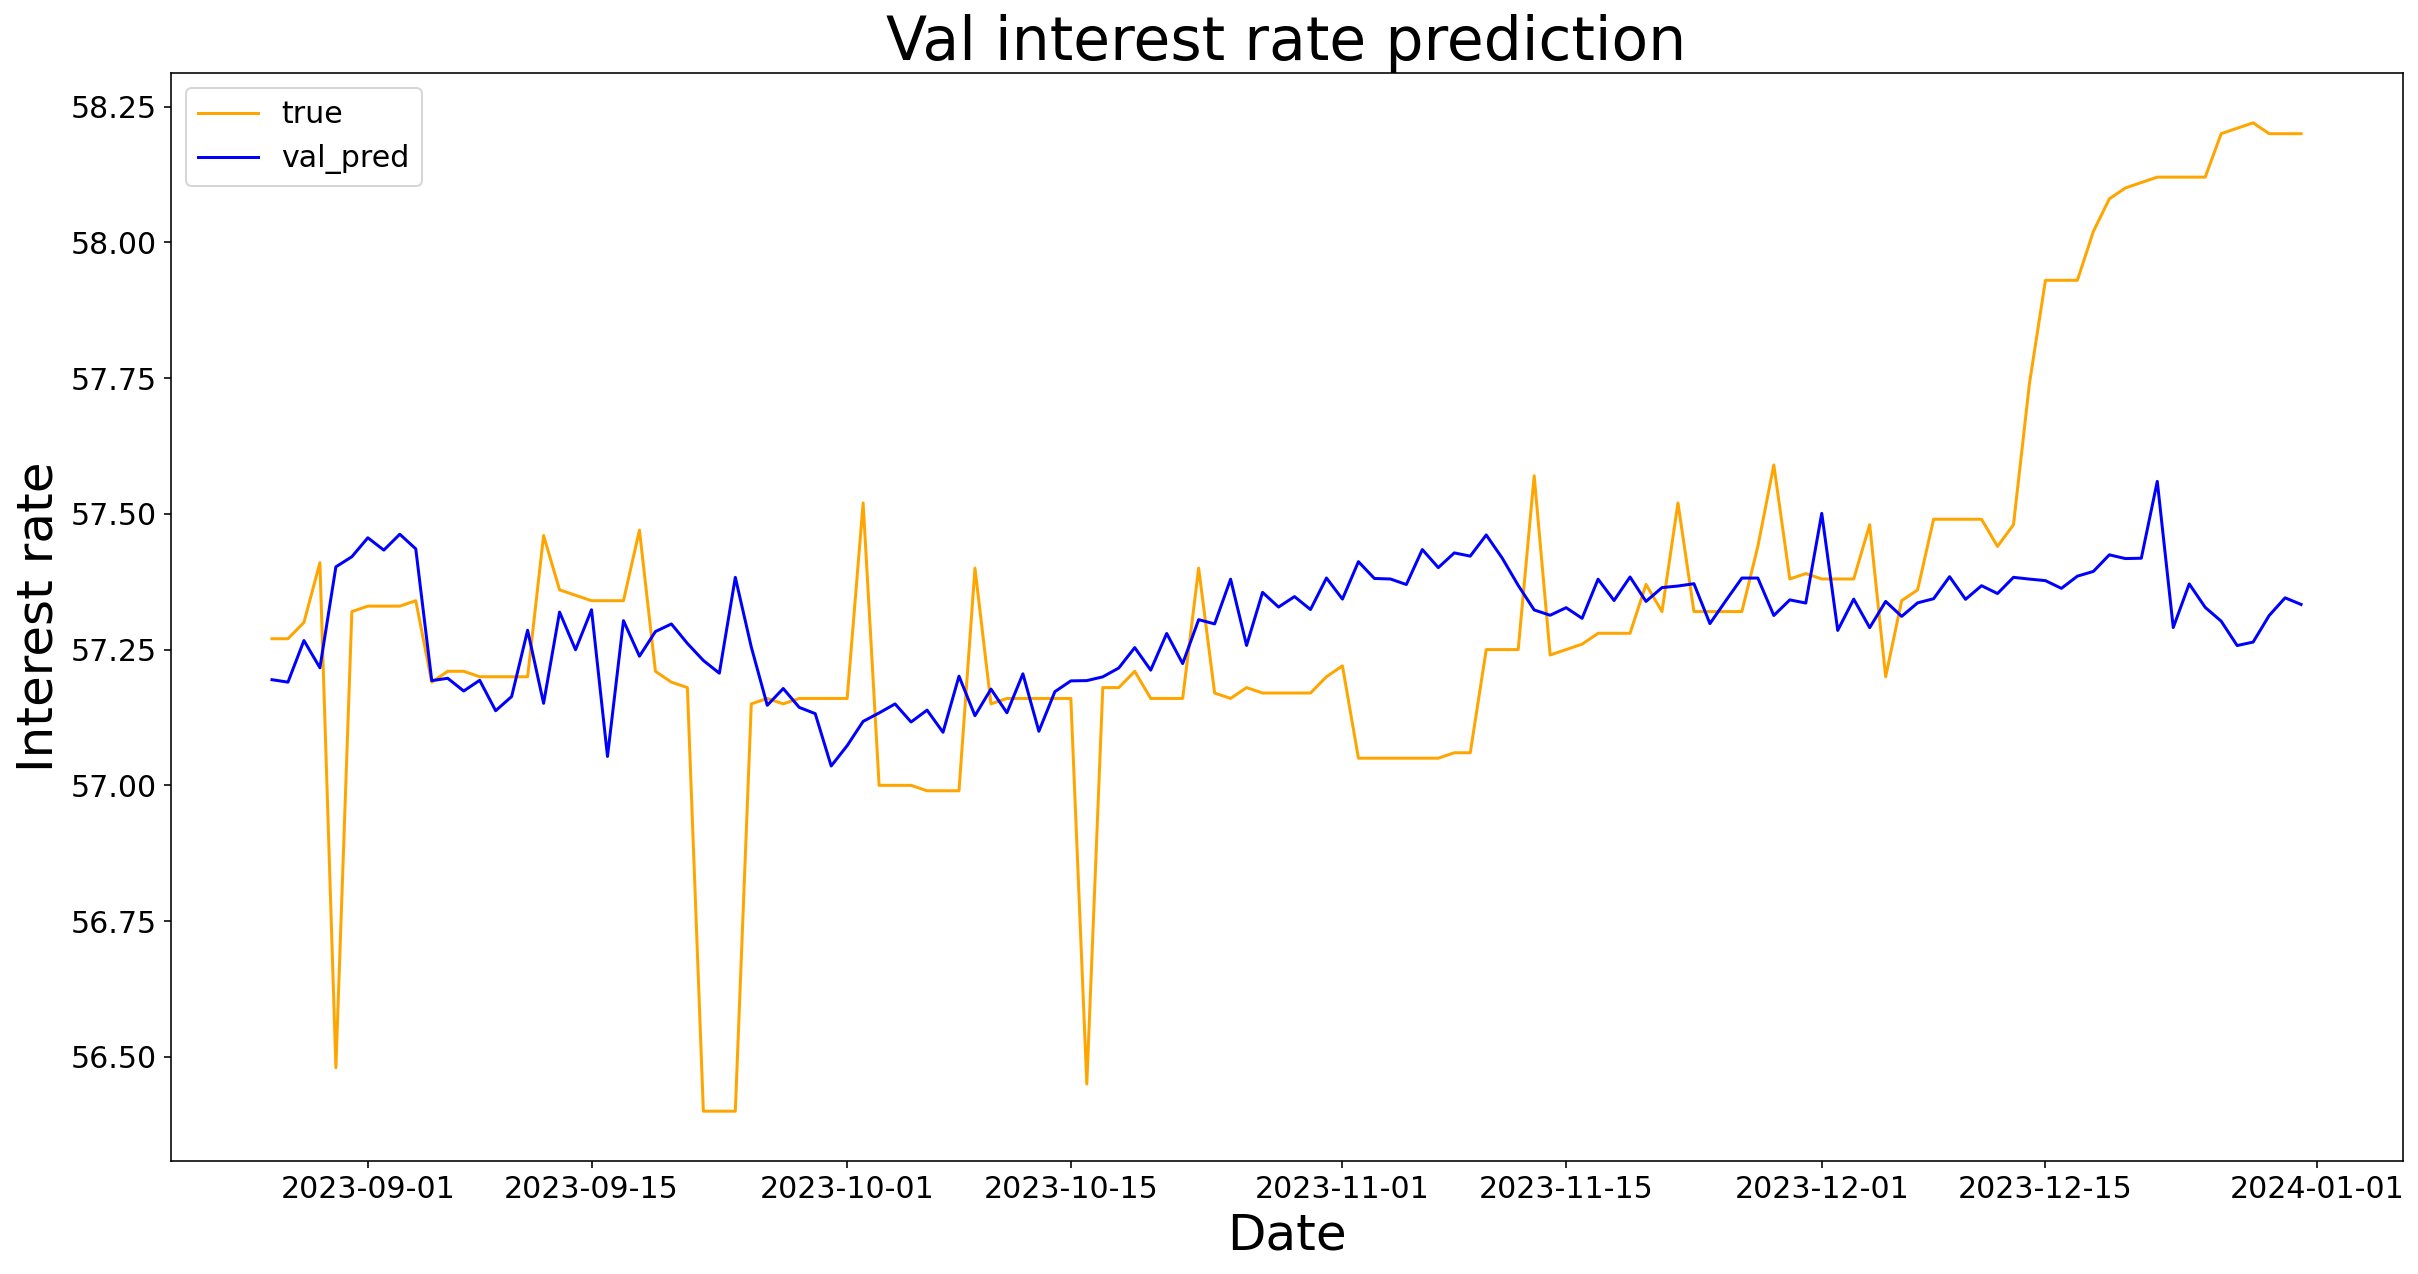

In [8]:
plt.title("Val interest rate prediction", fontsize = 30)
plt.plot(val_dates, val, color = 'orange', label = 'true')
plt.plot(val_dates, val_pred, color = 'blue', label = 'val_pred')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Interest rate", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

In [9]:
train = scaler.fit_transform(np.array(rates[:-period]).reshape(-1, 1))
X_train, y_train = create_sequences(train, best_train_batch)
best_model = XGBRegressor(random_state=42, n_estimators=1000, max_depth=best_max_depth, eta=best_eta)
best_model.fit(X_train, y_train, verbose=False)
X_train_ = train[-best_train_batch:].reshape(1, best_train_batch)
test_pred = []
for i in range(period):
    next_pred = best_model.predict(X_train_)
    X_train_ = X_train_.reshape(X_train_.shape[1])[1:]
    X_train_ = np.append(X_train_, next_pred)
    X_train_ = X_train_.reshape(1, best_train_batch)
    test_pred.append(next_pred[0])

test_pred = scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(period)
test_RMSE = mean_squared_error(test, test_pred, squared=False)
test_rel_error = ((abs(test - test_pred)) / test) * 100
print("Test RMSE = %.3f" % test_RMSE, sep="")
print("Test relative error = %.3f" % test_rel_error.mean(), '%', sep="")
print("Last test relative error = %.3f" % test_rel_error[-1], '%', sep="")

Test RMSE = 5.346
Test relative error = 8.726%
Last test relative error = 9.713%


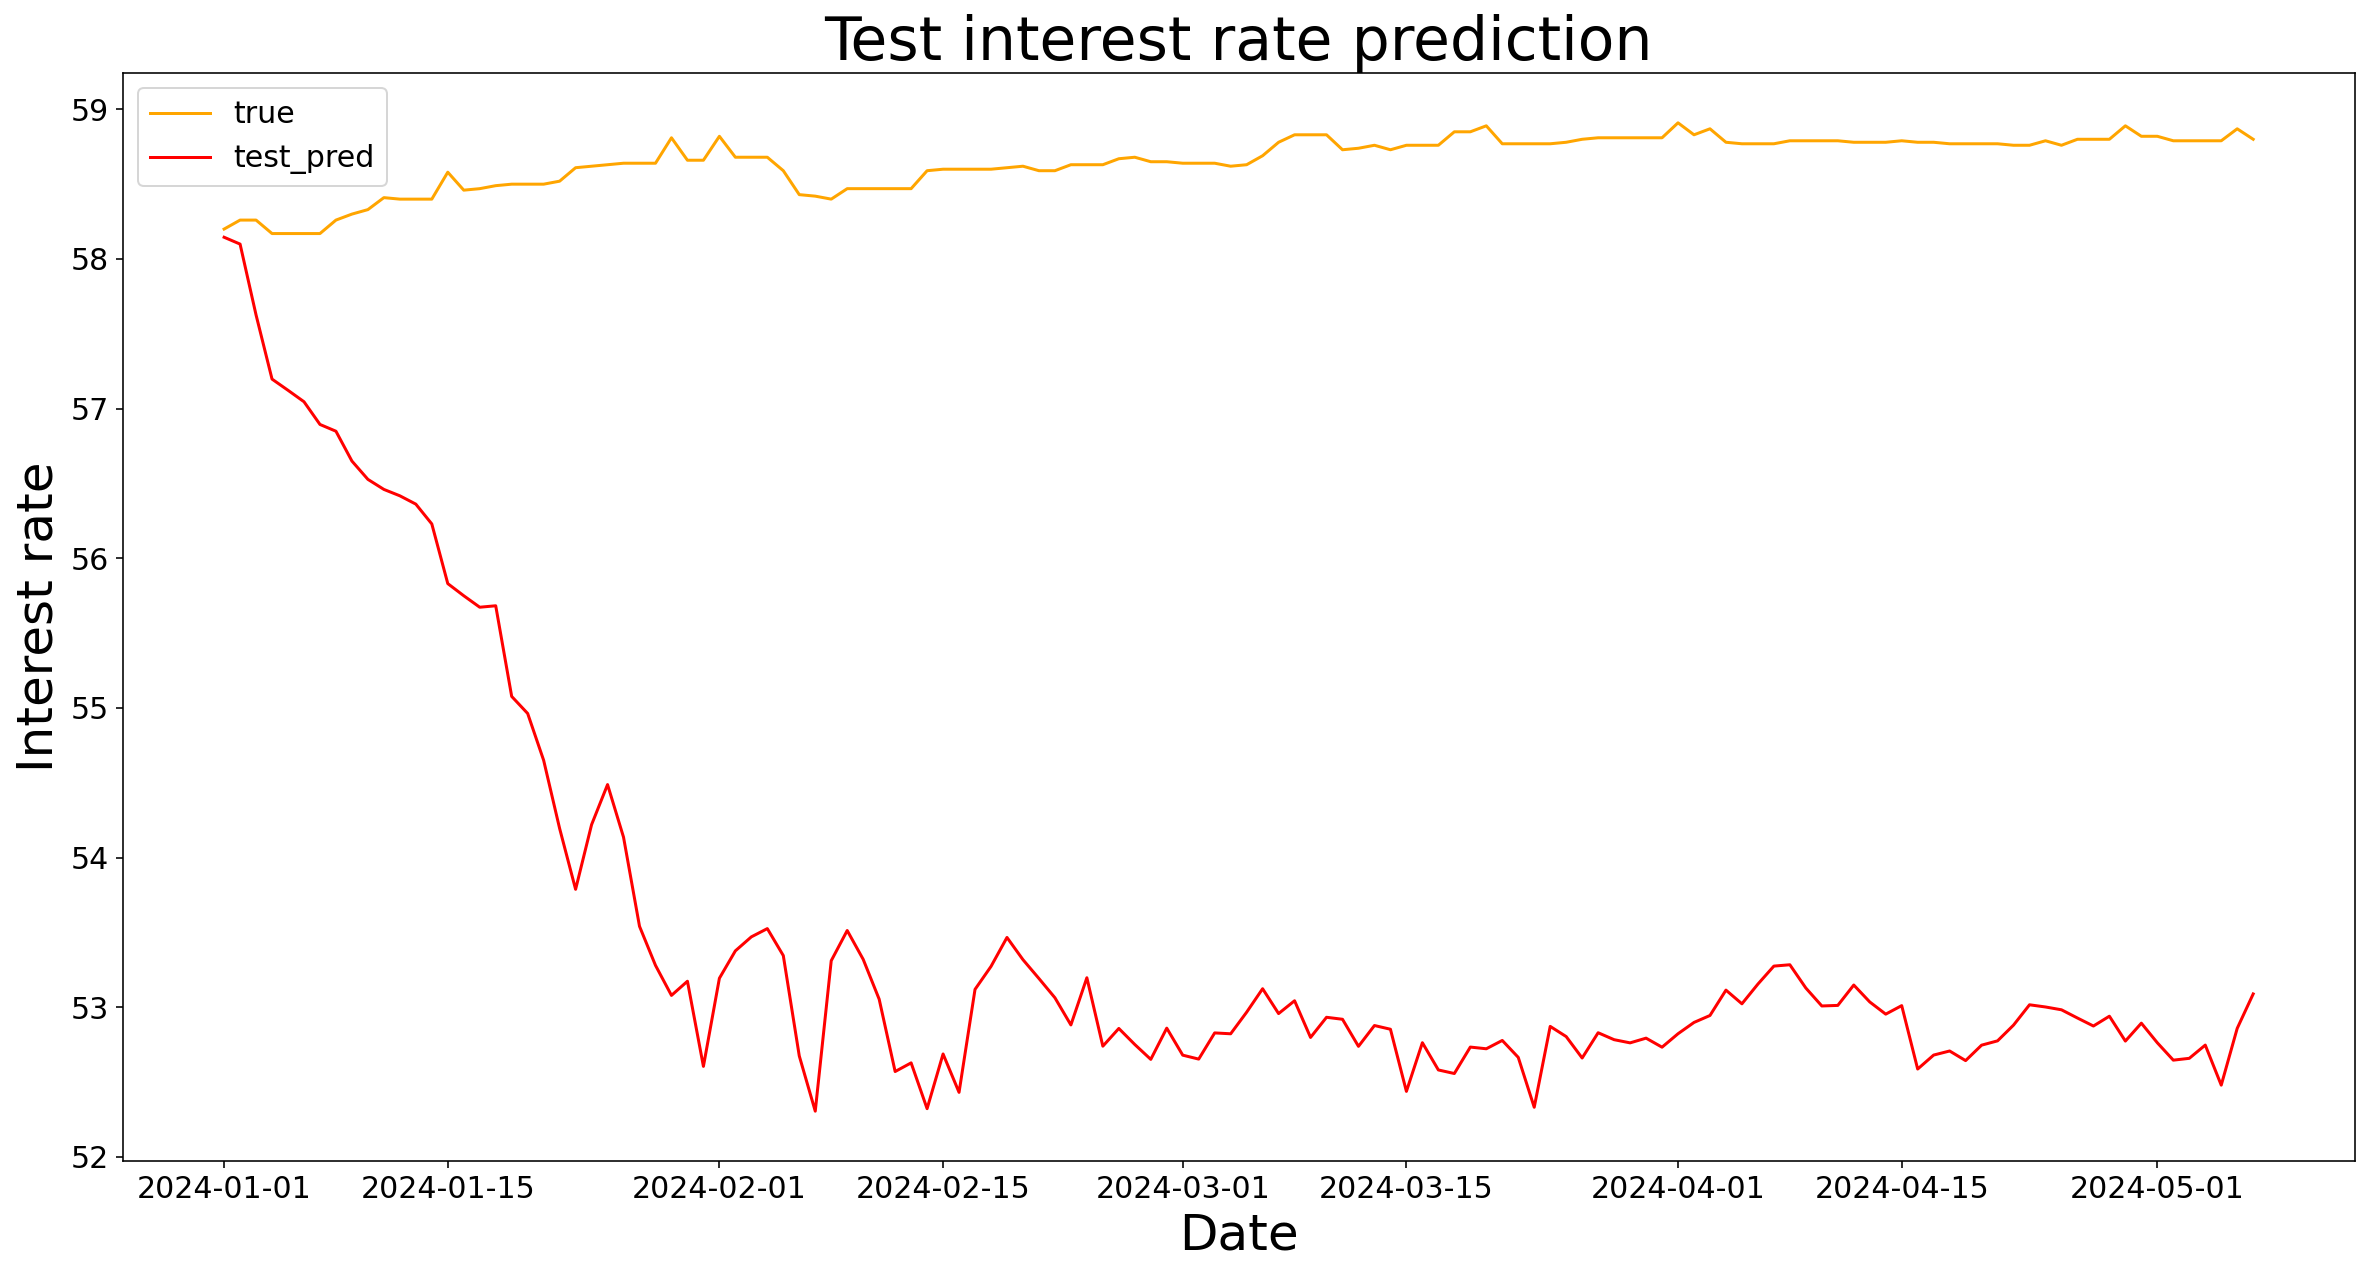

In [10]:
plt.title("Test interest rate prediction", fontsize = 30)
plt.plot(test_dates, test, color = 'orange', label = 'true')
plt.plot(test_dates, test_pred, color = 'red', label = 'test_pred')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Interest rate", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()